## This notebook outlines an example of how to arrive at modeled ice melt at a single stake location for a single melt season. The example stake given is Kenn Lo for summer 2019. Steps are:

### 1. Using lapse rate, extrapolate USGS temperature record to the stake elevation and cumulative sum positive degree days
### 2. Calculate ice melt degree day factor 
### 3. Extend modeled melt record to shoulder seasons 
### 4. (not shown here) Compare precipitation record to modeled melt record to identify annual mass extrema

In [1]:
# imports
import os
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
import pandas as pd
from scipy import stats
import matplotlib.dates as mdates
# set up
pd.plotting.register_matplotlib_converters()
plt.style.use('ggplot')

# data folder
format_data = r'C:\Users\tamaral\Documents\GIP-2020\Kennicott\PROJECT\Kennicott-Glacier-Sharing\DATA'
lr = -4.06 # c/km - derived from LR_Exploration median value

### First, input stake information and load USGS temperature record

In [2]:
# --- stake variables
kl_el = 790 # meters
kl_spring = pd.Timestamp('2019-06-07',tz='US/Alaska') # date of spring visit
kl_fall = pd.Timestamp('2019-08-22',tz='US/Alaska') # date of fall visit
kl_swe = 5.28 # m w.e. ice ablated between visits. 
usgs_el = 409 # meters,  appr. elevation of usgs gage station

# ---load usgs data
dtvg = pd.read_pickle(os.path.join(format_data,'daily_tavg.pickle')) # read in temperature data w/ filled usgs record
dtvg.columns # just tavg for usgs, buri, and gates
# identify dates of shoulder season .... can edit these dates as appropriate
start = pd.Timestamp('2019-03-01',tz='US/Alaska')
end = pd.Timestamp('2019-11-01',tz='US/Alaska')

### 1. Extrapolate temperature record and cumulative sum positive degree days at stake location

In [3]:
# --- construct new dataframe for stake variables
kl = pd.DataFrame(index=pd.date_range(start,end,freq='D'))
kl['usgs'] = dtvg.loc[slice(start,end),'usgs'] # grab usgs temperatures
site_diff = (kl_el - usgs_el) / 1000 # convert to km
kl['stake'] = kl.usgs + (lr * site_diff) # calculate synthetic stake temps

#### Plot extrapolated temperature record to check...

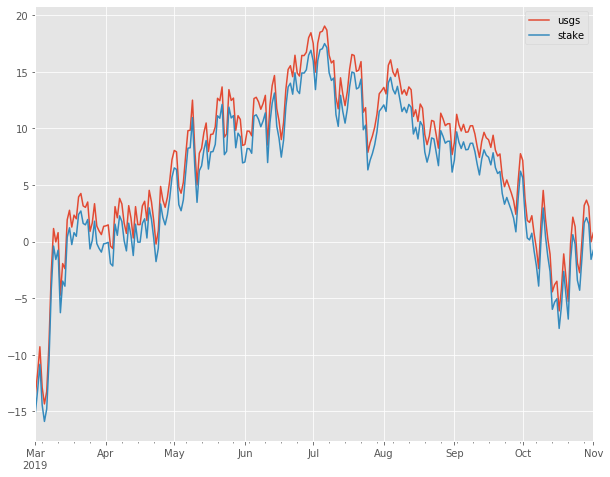

In [4]:
plt.figure(figsize=(10,8))
kl.usgs.plot(label='usgs')
kl.stake.plot(label='stake')
plt.legend()
plt.show()

### 2. Fit melt rate parameter for ice

In [5]:
# --- fit melt rate parameter (a = dd*ki)
dddf = kl.loc[slice(kl_spring,kl_fall),'stake'] # new dataframe for just days between visits
dd = dddf.loc[dddf > 0].sum() # sum degree days
ki = (kl_swe * 1000) / dd   # units mm / d*C
# print out value
print( 'Degree day ice factor for Kenn Low stake ({0} m) for summer 2019 is {1:.2f} mm/d*C'
      .format(kl_el,ki))

Degree day ice factor for Kenn Low stake (790 m) for summer 2019 is 5.66 mm/d*C


### 3. Model ice melt out to ends of shoulder season dates as defined above

In [6]:
# ---- Modeled ice ablation records
kl['dd'] = kl['stake'].where(kl['stake'] > 0, 0) # columns of individual degree days
kl['cumdd'] = kl['dd'].cumsum() #  cumulative DD column
kl['cumabl'] = kl['cumdd'].multiply(ki / 1000) # cumulative ablation column (meters)
kl['abl'] = kl['cumabl'].diff().multiply(1000) # daily ice ablation in mm


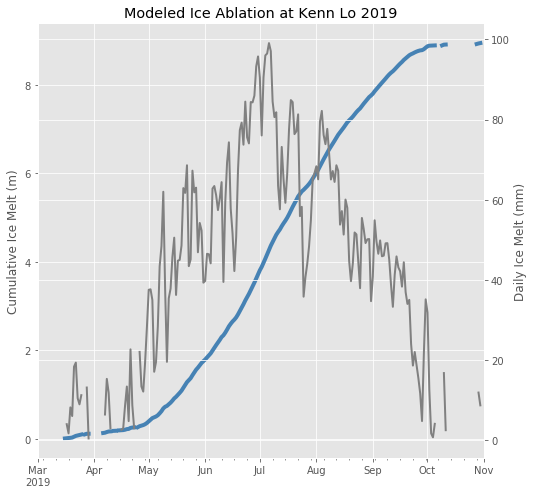

In [7]:
# --- Visualize modeled melt
fig,ax = plt.subplots(figsize=(8,8))
ax.set_title('Modeled Ice Ablation at Kenn Lo 2019')
kl.cumabl.plot(ax=ax,linewidth=4,color='steelblue')
ax.set_ylabel('Cumulative Ice Melt (m)')
# plot daily melt
ax2 = ax.twinx()
ax2.set_ylabel('Daily Ice Melt (mm)')
kl.abl.plot(ax=ax2,linewidth=2,color='gray')
plt.show()

### For situations where modeled melt using the DDF does not exactly equal the measured ice melt between spring and fall visits, it will be more accurate to add modeled shoulder season melt to the empirical summer ice melt to derive the full season melt amount.  

In [9]:
# ---- Modeled + empirical ice ablation (For when DDF has some error...)
pre_visit = kl.loc[(kl_spring - pd.Timedelta(1,'D')),'cumabl'] # m of modeled ice melt before spring visit, not counting visit day
post_visit = kl.loc[end,'cumabl'] - kl.loc[kl_fall,'cumabl']# m of modeled ice melt post visit, not counting visit day
full_season = pre_visit + kl_swe + post_visit # add in empirical ice melt b/w visits
print('Full Season Melt for {0} during {1} is {2:.1f} m w.e.'.format('Kenn Lo',kl_spring.year,full_season))


Full Season Melt for Kenn Lo during 2019 is 8.9 m w.e.
